# CTR Prediction

#### This project was completed in July 2019 while I was studying data science at WeCloudData and edited in August 2020 for my portfolio. The purpose was to clean and explore data from an online ad agency, then build and test machine learning models that predict whether a user will click on an ad or not. My machine learning skills have progressed substantially since first completing this project, so I have added in a streamlined grid search and modelling section so that most of the machine learning and relevant outputs come from just 2 cells. The initial project is included afterwards as further illustration of my abilities. 

In [1]:
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import time

from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, roc_auc_score

In [2]:
df = pd.read_csv('CTR_prediction.csv')
df

,Unnamed: 0,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime
0,1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,View,Facebook,300x600,Carter's,Pink,0.171601
1,2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,View,Facebook,300x250,Burberry,Red,4.303945
2,3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,View,Facebook,728x90,Disney,Yellow,0.868106
3,4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,View,Facebook,320x50,Carter's,Yellow,0.802647
4,5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,View,instagram.com,300x250,Gap,Gold,0.627148
...,...,...,...,...,...,...,...,...,...
999995,999996,AMsySZY-9Mzh_xjk57_PBNO_8QRO,1508108130372165,View,instagram.com,300x250,Old Navy,Yellow,0.049011
999996,999997,AMsySZY-KoDAx1qJv15SZ9lKO2QF,1516760241253562,View,Twitter,320x480,JoeFresh,Yellow,0.059118
999997,999998,AMsySZZGRYHeXVjPP2Rr6F-kjFc3,1502841951670170,View,Other,300x250,JoeFresh,Pink,0.025754
999998,999999,AMsySZaSAhXiCSGhaCLWcoLse-0i,1517068511614322,View,Facebook,300x250,Old Navy,Pink,0.453710


## Exploratory Data Analysis

In [3]:
# Drop secondary index column
df = df.drop(columns = 'Unnamed: 0')

In [4]:
# ~218K unique ID's
df.groupby('ID').size().sort_values(ascending = False).head()

ID
AMsySZaSHnOuwfEjIHSMTU237tQS    2231
AMsySZYzetqojeg0GiqNxk1-E49j    2214
AMsySZYo44CqBz2TZpaBq_4ycVeA    1876
AMsySZap-f-WDKrbqevE25h4Ywf7    1479
AMsySZbDZnAE8-ok03JhD3tWzfOM    1007
dtype: int64

In [5]:
# The target is very imbalanced in this data set - must be dealt with
# A model that ONLY predicts no click would be 99.99% accurate
# Hard for model to learn from so few click instances
df['Action'].value_counts()

View     999756
Click       244
Name: Action, dtype: int64

In [6]:
# 244 clicks across 211 users - a fair amount of multi-click users
df[df['Action']=='Click'].groupby('ID').Action.value_counts().sort_values(ascending = False).head(25)

ID                            Action
AMsySZZFgj4VZQMNFAVg7RhrtwK9  Click     5
AMsySZaXOUFw6abC5kKlstcXiWgR  Click     4
AMsySZahqJUP-lAM8o0uuEn1wCQo  Click     3
AMsySZZx1kWE-I4zTCBuxc9O4aMB  Click     3
AMsySZZd-ZCF7AIfpXFQDcfP_iCS  Click     2
AMsySZalB29ZTB6Ptcg3Y0ap_bck  Click     2
AMsySZbDm0L1w-ZOFh0dwDZwivJW  Click     2
AMsySZYtpCq1jCDG6_MR6U9RDbfC  Click     2
AMsySZaasNDMCGrLUcn83hnWDk5h  Click     2
AMsySZa_O37Evi5G-Px96BTnzINB  Click     2
AMsySZYvMMdDCD_00kMb45GwIDkn  Click     2
AMsySZZgI5QPn4cAnWH1Dg0rIcaY  Click     2
AMsySZZ3DCEtyLcufbn6rcs0boOe  Click     2
AMsySZZ5MdJOa9wytcg6Fu7WFMng  Click     2
AMsySZaRgpYVIPVBF_XQ9JkiQ19Q  Click     2
AMsySZbecgtjEn-gFIDjk-KNI9yJ  Click     2
AMsySZZXX7DfbQj_r0FPZnuBnuRo  Click     2
AMsySZZFgLWhfpJDp12i5ACVJ5fQ  Click     2
AMsySZZzlxwu5NPg4AjHv5W0N1xr  Click     2
AMsySZZ9neA0ex9ex0EQUPxxly3Y  Click     2
AMsySZaoadfxX-w7wnFkcYn-QOiF  Click     2
AMsySZZBGEKWlMNMsnbQ13mbopov  Click     2
AMsySZaLOGUmkhuxPS6Q1M5kzUdj  Click    

In [7]:
# Exploring profile of clickers
df[df['Action']=='Click'].head(25)

,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime
812,AMsySZb8b-J-eW7JOEuTeIUQ5qMg,1514261353516880,Click,Kijiji,160x600,JoeFresh,other,NaN
1117,AMsySZa1aKtjs-l2SIH7D7blDpA5,1507334361698311,Click,Amazon,160x600,Old Navy,Yellow,0.024737
4639,AMsySZZBGEKWlMNMsnbQ13mbopov,1513439807056947,Click,Facebook,300x250,Disney,Pink,0.474729
15419,AMsySZYtpCq1jCDG6_MR6U9RDbfC,1514698137893072,Click,Facebook,160x600,Carter's,Yellow,2.190019
24752,AMsySZamYm9kMjJQrErPrBESOpMv,1515529793236156,Click,Facebook,300x250,JoeFresh,Pink,0.789268
29996,AMsySZYB1PocEUlgcuefzTdqHv3J,1501254462378128,Click,Facebook,300x250,Disney,Red,3.460984
35219,AMsySZZsUq8QBOnQjA10iNSPCrKn,1510162749639290,Click,Kijiji,160x600,Carter's,Yellow,0.287192
37995,AMsySZb9IAzCsN1E995MMl61bk6A,1506259360502506,Click,Other,Other,Zara,Yellow,0.514487
48155,AMsySZaovu92_v0wcHdSAkMhgGdK,1514591674976088,Click,Amazon,728x90,JoeFresh,Gold,1.148191
55597,AMsySZaFZKflnrTSbjIOV7VnwmOr,1501085193724023,Click,Yahoo,1200x627,Old Navy,Pink,0.488769


In [8]:
#Sync multiple 'Other' values
df.loc[df['BannerSize']=='other','BannerSize'] = 'Other'

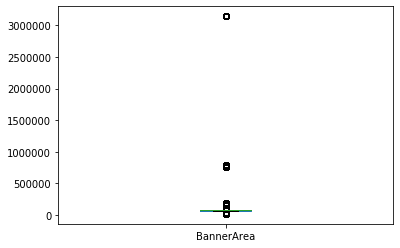

In [9]:
#Convert BannerSize into an integer as BannerArea
#Other and 1x1 banners will be treated as NaNs since they are uninterpretable
df['BannerArea'] = df.loc[(df['BannerSize']!='Other')&(df['BannerSize']!='1x1'),'BannerSize'].str.split('x').str[0].astype(int) * \
df.loc[(df['BannerSize']!='Other')&(df['BannerSize']!='1x1'),'BannerSize'].str.split('x').str[1].astype(int)
df['BannerArea'].plot(kind='box');

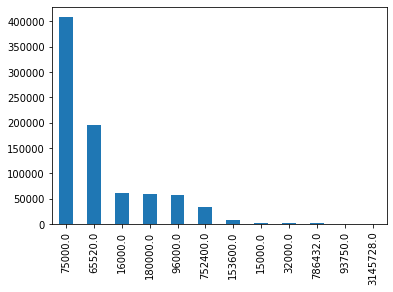

In [10]:
df['BannerArea'].value_counts().plot(kind='bar');

In [11]:
#3145728 is nonsensical for banner size
df[df['BannerArea']==3145728]

,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime,BannerArea
1971,AMsySZb1uvflpxNnB-JW1mYMeXNU,1514771532317121,View,Other,1536x2048,Banana Republic,Pink,0.422096,3145728.0
2994,AMsySZbXT3KjbsMHRgvtv48O7lU7,1514917354066716,View,Other,1536x2048,Carter's,Gold,1.942995,3145728.0
6076,AMsySZbN7TvAH7FPxrJIr--Pgh3R,1514639384444585,View,Other,1536x2048,Disney,Gold,0.159148,3145728.0
11646,AMsySZaKRf3m-ZH2Wkj6IkNhc7if,1513884594971255,View,Other,1536x2048,Carter's,Pink,0.535529,3145728.0
18982,AMsySZaUgq88GfgbHxREBrvNfGvX,1513624342217129,View,Other,1536x2048,JoeFresh,Gold,2.151378,3145728.0
...,...,...,...,...,...,...,...,...,...
992215,AMsySZb7rC4Pd7h1bzPo5AJW0Qml,1514034978021486,View,Other,1536x2048,Disney,Pink,0.775058,3145728.0
992729,AMsySZZ0C3kvPDENiNelIUu-jzdZ,1512070423151043,View,Other,1536x2048,Old Navy,Gold,1.278896,3145728.0
994967,AMsySZYmV0ejhsHenuptMU8ueSlD,1513193152497476,View,Other,1536x2048,JoeFresh,Yellow,0.379503,3145728.0
995028,AMsySZZqPOObdrRdM-AE4kRNmCXG,1513727493640248,View,Other,1536x2048,Old Navy,Blue,0.221608,3145728.0


In [15]:
#Since none of these actions are clicks they can be dropped
df = df[df['BannerArea']!=3145728]
df[df['BannerArea']==3145728]

,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime,BannerArea


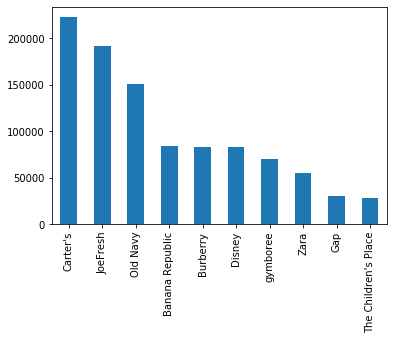

In [16]:
df['Brand'].value_counts().plot(kind='bar');

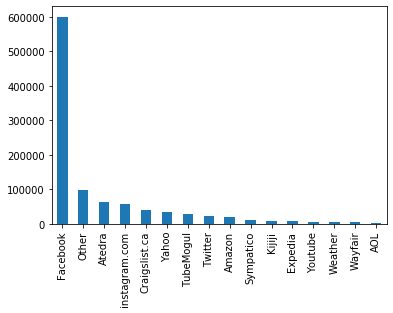

In [17]:
df['Website'].value_counts().plot(kind='bar');

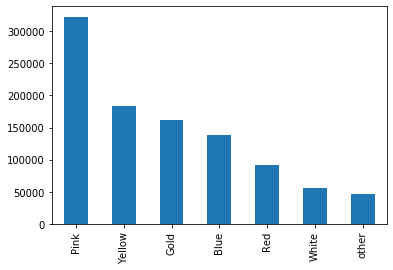

In [18]:
df['colour'].value_counts().plot(kind='bar');

In [19]:
df.describe()

,ActionTime,InteractionTime,BannerArea
count,9.996810e+05,999673.000000,828778.000000
mean,1.508365e+15,0.998674,105686.118386
std,4.362332e+12,0.998196,138404.467213
min,1.500991e+15,0.000002,15000.000000
25%,1.505163e+15,0.288694,65520.000000
50%,1.507714e+15,0.693064,75000.000000
75%,1.511495e+15,1.382775,75000.000000
max,1.517358e+15,13.385281,786432.000000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999681 entries, 0 to 999999
Data columns (total 9 columns):
ID                 999681 non-null object
ActionTime         999681 non-null int64
Action             999681 non-null object
Website            999681 non-null object
BannerSize         999681 non-null object
Brand              999681 non-null object
colour             999681 non-null object
InteractionTime    999673 non-null float64
BannerArea         828778 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 76.3+ MB


In [21]:
df.isnull().sum()

ID                      0
ActionTime              0
Action                  0
Website                 0
BannerSize              0
Brand                   0
colour                  0
InteractionTime         8
BannerArea         170903
dtype: int64

In [22]:
# Can NOT drop null Interaction time because it contains 5 clicks
# Data is too imbalanced to drop these records
df[df.InteractionTime.isnull()]

,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime,BannerArea
28,AMsySZbU2U0u2CDEQPae5UEvj7uh,1513974448167954,View,Facebook,728x90,Gap,Gold,NaN,65520.0
154,AMsySZZNSd4doewEvAFWe9U7SEub,1503968584487308,View,Facebook,320x50,Banana Republic,Gold,NaN,16000.0
812,AMsySZb8b-J-eW7JOEuTeIUQ5qMg,1514261353516880,Click,Kijiji,160x600,JoeFresh,other,NaN,96000.0
98269,AMsySZbCULOmzvMOl_jxgAPZnhmV,1512573518334683,Click,Facebook,300x250,Disney,Blue,NaN,75000.0
243356,AMsySZYtpCq1jCDG6_MR6U9RDbfC,1514698137892676,Click,Facebook,160x600,JoeFresh,Pink,NaN,96000.0
243357,AMsySZa6M_Z79mOnUWF9P8nKac5-,1516738555981098,View,Facebook,300x250,Carter's,Yellow,NaN,75000.0
331970,AMsySZbyqkZuERDU8VBWoJX_F4tD,1515278217655536,Click,Other,1x1,Old Navy,Pink,NaN,NaN
451827,AMsySZYZjTd1kTYooOpACb0cTDL2,1515692970262672,Click,Facebook,728x90,Old Navy,Pink,NaN,65520.0


## Feature Engineering

In [23]:
#Convert to DateTime and drop redundant 'ActionTime'
df['DateTime'] = pd.to_datetime(df['ActionTime'], unit='us')
df = df.drop(columns = 'ActionTime')
df['DateTime'].head()

0   2017-10-23 12:30:59.495365
1   2017-08-16 01:37:49.736117
2   2017-12-25 02:37:11.528120
3   2018-01-09 19:59:12.591896
4   2017-10-09 02:06:49.374045
Name: DateTime, dtype: datetime64[ns]

In [24]:
# Explore profile of biggest clicker
df[df['ID']=='AMsySZZFgj4VZQMNFAVg7RhrtwK9'].sort_values('DateTime')

,ID,Action,Website,BannerSize,Brand,colour,InteractionTime,BannerArea,DateTime
489317,AMsySZZFgj4VZQMNFAVg7RhrtwK9,Click,Facebook,300x250,The Children's Place,Red,2.733071,75000.0,2017-12-05 16:39:57.963630
307132,AMsySZZFgj4VZQMNFAVg7RhrtwK9,Click,Facebook,728x90,Burberry,Gold,0.139913,65520.0,2017-12-18 15:48:25.634898
397989,AMsySZZFgj4VZQMNFAVg7RhrtwK9,Click,Facebook,728x90,JoeFresh,Blue,0.482897,65520.0,2017-12-19 14:35:43.345732
402851,AMsySZZFgj4VZQMNFAVg7RhrtwK9,View,Facebook,728x90,Carter's,Blue,0.175041,65520.0,2017-12-20 21:49:10.175080
301185,AMsySZZFgj4VZQMNFAVg7RhrtwK9,View,Facebook,300x250,Carter's,Gold,0.560611,75000.0,2017-12-27 21:08:55.263678
862175,AMsySZZFgj4VZQMNFAVg7RhrtwK9,Click,Facebook,300x250,Old Navy,Yellow,0.213108,75000.0,2018-01-10 21:32:08.085104
712125,AMsySZZFgj4VZQMNFAVg7RhrtwK9,View,Facebook,728x90,gymboree,Pink,1.914496,65520.0,2018-01-22 20:26:12.673974
67771,AMsySZZFgj4VZQMNFAVg7RhrtwK9,Click,Facebook,300x250,Burberry,Gold,0.183718,75000.0,2018-01-24 16:33:28.070674
976997,AMsySZZFgj4VZQMNFAVg7RhrtwK9,View,Facebook,728x90,Old Navy,Gold,0.363942,65520.0,2018-01-26 17:23:08.445884
537669,AMsySZZFgj4VZQMNFAVg7RhrtwK9,View,Facebook,300x600,JoeFresh,Red,0.380214,180000.0,2018-01-29 21:44:36.521835


In [25]:
# Extract Hour, DayWeek, Month, Year columns
df['Hour'] = df['DateTime'].dt.hour
df['DayWeek'] = df['DateTime'].dt.dayofweek
df['Month'] = df['DateTime'].dt.month
df['Year'] = df['DateTime'].dt.year

In [26]:
#Create 'is it a Weekend' column
df['Weekend'] = df['DayWeek'].isin([5, 6]).astype(int)

In [27]:
#Bin hours into 4 seperate 6 hour blocks
df['TimeBin'] = pd.cut(df['Hour'],[0,6,12,18,24], include_lowest = True)
df['TimeBin'].head()

0      (6.0, 12.0]
1    (-0.001, 6.0]
2    (-0.001, 6.0]
3     (18.0, 24.0]
4    (-0.001, 6.0]
Name: TimeBin, dtype: category
Categories (4, interval[float64]): [(-0.001, 6.0] < (6.0, 12.0] < (12.0, 18.0] < (18.0, 24.0]]

In [28]:
# Convert Action=='Click' into binary Clicked column
df['Clicked'] = (df['Action']=='Click').astype(int)
df['Clicked'].value_counts()

0    999437
1       244
Name: Clicked, dtype: int64

In [29]:
#Converted Action=='View' into binary Viewed column
df['Viewed'] = (df['Action']=='View').astype(int)
df['Viewed'].value_counts()

1    999437
0       244
Name: Viewed, dtype: int64

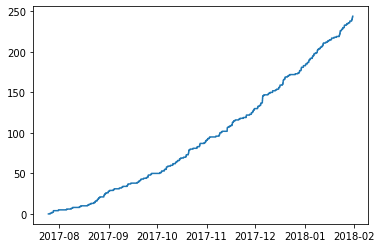

In [66]:
#Total clicks over time
df2 = df.sort_values('DateTime').reset_index()
plt.plot(df2['DateTime'], df2['Clicked'].transform('cumsum'));

In [28]:
#Cumulative clicks per user at the time of an impression
#If done carefully to avoid data leakage, we can use past clicks/views at time of interaction as feature
df['ClickCount'] = df.sort_values('DateTime').groupby('ID')['Clicked'].transform('cumsum')

In [29]:
#Confirming cumsum worked as intended
df[df['Action']=='Click'].sort_values('DateTime').head(25)

,ID,Action,Website,BannerSize,Brand,colour,InteractionTime,BannerArea,DateTime,Hour,DayWeek,Month,Year,Weekend,TimeBin,Clicked,Viewed,ClickCount
55597,AMsySZaFZKflnrTSbjIOV7VnwmOr,Click,Yahoo,1200x627,Old Navy,Pink,0.488769,752400.0,2017-07-26 16:06:33.724023,16,2,7,2017,0,"(12.0, 18.0]",1,0,1
353193,AMsySZZMEpE-coa41TpTUHiuGUTM,Click,Facebook,300x250,Carter's,Pink,2.354688,75000.0,2017-07-27 18:26:37.474599,18,3,7,2017,0,"(12.0, 18.0]",1,0,1
29996,AMsySZYB1PocEUlgcuefzTdqHv3J,Click,Facebook,300x250,Disney,Red,3.460984,75000.0,2017-07-28 15:07:42.378128,15,4,7,2017,0,"(12.0, 18.0]",1,0,1
581558,AMsySZYtNKSHzYcHFhzH63-xOanX,Click,Facebook,728x90,Burberry,Red,0.367803,65520.0,2017-07-28 16:39:30.911979,16,4,7,2017,0,"(12.0, 18.0]",1,0,1
649353,AMsySZaU5VU-fJVQ2V8lqmqCAx8p,Click,Yahoo,1200x627,Burberry,Gold,0.847616,752400.0,2017-07-31 18:30:51.550972,18,0,7,2017,0,"(12.0, 18.0]",1,0,1
496426,AMsySZafzCvCEi9du4sk57lF0cMB,Click,Atedra,300x600,Carter's,Pink,1.504534,180000.0,2017-08-05 20:27:11.934892,20,5,8,2017,1,"(18.0, 24.0]",1,0,1
886258,AMsySZYxZhjY4e-dSeKLBQwb-WSE,Click,Atedra,300x250,Carter's,Red,0.221381,75000.0,2017-08-08 18:10:09.600634,18,1,8,2017,0,"(12.0, 18.0]",1,0,1
367417,AMsySZZX9WvxHsG1AAAw3lmWNnRq,Click,Facebook,160x600,Disney,Yellow,0.702667,96000.0,2017-08-09 15:14:57.425839,15,2,8,2017,0,"(12.0, 18.0]",1,0,1
461631,AMsySZYNUXFJVLkOz7acesbU2yLT,Click,Other,300x250,gymboree,Pink,2.244441,75000.0,2017-08-13 20:50:23.220624,20,6,8,2017,1,"(18.0, 24.0]",1,0,1
624321,AMsySZbLJnPdxWp1L6aaw7XVYGkg,Click,Facebook,300x250,JoeFresh,Pink,2.164042,75000.0,2017-08-14 16:54:18.021913,16,0,8,2017,0,"(12.0, 18.0]",1,0,1


In [30]:
#Must -1 so as to not count the current impression and leak data
df['ClickCount'] = df['ClickCount']-1

#Must reset -1 ClickCount values to 0 since -1 is an impossible value
df.loc[df['ClickCount']==-1,'ClickCount'] = 0

In [31]:
df['ClickCount'].value_counts()

0    999913
1        63
3        15
2         6
4         3
Name: ClickCount, dtype: int64

In [32]:
#Cumulative views per user at the time of an impression
df['ViewCount'] = df.sort_values('DateTime').groupby('ID')['Viewed'].transform('cumsum')
df['ViewCount'].head()

0    33
1     7
2     3
3     1
4    11
Name: ViewCount, dtype: int32

In [33]:
#Must -1 so as to not count the current impression and leak data
df['ViewCount'] = df['ViewCount']-1

#Must reset -1 ClickCount values to 0 since -1 is an impossible value
df.loc[df['ViewCount']==-1,'ViewCount'] = 0

In [34]:
df['ViewCount'].value_counts().head()

0    218742
1    117410
2     77809
3     57121
4     44646
Name: ViewCount, dtype: int64

In [35]:
#Cumulative InteractionTime per user at the time of an impression
df['TimeCount'] = df.sort_values('DateTime').groupby('ID')['InteractionTime'].transform('cumsum')
df['TimeCount'].head()

0    28.844307
1    13.156188
2     1.935283
3     0.802647
4    10.752797
Name: TimeCount, dtype: float64

In [36]:
#See all columns
with pd.option_context('display.max_columns', None):
    display(df.head())

,ID,Action,Website,BannerSize,Brand,colour,InteractionTime,BannerArea,DateTime,Hour,DayWeek,Month,Year,Weekend,TimeBin,Clicked,Viewed,ClickCount,ViewCount,TimeCount
0,AMsySZbNg8SBwPtj7IGHnip_8aY0,View,Facebook,300x600,Carter's,Pink,0.171601,180000.0,2017-10-23 12:30:59.495365,12,0,10,2017,0,"(6.0, 12.0]",0,1,0,32,28.844307
1,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,View,Facebook,300x250,Burberry,Red,4.303945,75000.0,2017-08-16 01:37:49.736117,1,2,8,2017,0,"(-0.001, 6.0]",0,1,0,6,13.156188
2,AMsySZYoK8_bD0hGv4zu0iRn1TFo,View,Facebook,728x90,Disney,Yellow,0.868106,65520.0,2017-12-25 02:37:11.528120,2,0,12,2017,0,"(-0.001, 6.0]",0,1,0,2,1.935283
3,AMsySZahxpwLOWnMJj6RGATgwEOc,View,Facebook,320x50,Carter's,Yellow,0.802647,16000.0,2018-01-09 19:59:12.591896,19,1,1,2018,0,"(18.0, 24.0]",0,1,0,0,0.802647
4,AMsySZbqgfMBDtAqZz1jVRaOmX00,View,instagram.com,300x250,Gap,Gold,0.627148,75000.0,2017-10-09 02:06:49.374045,2,0,10,2017,0,"(-0.001, 6.0]",0,1,0,10,10.752797


## Modelling

In [37]:
#Year was dropped since the data only spans 18 months
#All other dropped columns were redundant or leak data
#Our target is whether an impression was clicked or not (1 for clicked, 0 for viewed)
X = df.drop(columns = ['DateTime', 'BannerSize', 'Action', 'ID', 'Clicked', \
                       'Viewed', 'Year'])
y = df['Clicked']

In [38]:
#Use One Hot encoding to obtain dummies for categorical variables
#Drop first was used to avoid having a redundant dummy column
X = pd.get_dummies(X, drop_first = True)
X.head()

,InteractionTime,BannerArea,Hour,DayWeek,Month,Weekend,ClickCount,ViewCount,TimeCount,Website_Amazon,...,Brand_gymboree,colour_Gold,colour_Pink,colour_Red,colour_White,colour_Yellow,colour_other,"TimeBin_(6.0, 12.0]","TimeBin_(12.0, 18.0]","TimeBin_(18.0, 24.0]"
0,0.171601,180000.0,12,0,10,0,0,32,28.844307,0,...,0,0,1,0,0,0,0,1,0,0
1,4.303945,75000.0,1,2,8,0,0,6,13.156188,0,...,0,0,0,1,0,0,0,0,0,0
2,0.868106,65520.0,2,0,12,0,0,2,1.935283,0,...,0,0,0,0,0,1,0,0,0,0
3,0.802647,16000.0,19,1,1,0,0,0,0.802647,0,...,0,0,0,0,0,1,0,0,0,1
4,0.627148,75000.0,2,0,10,0,0,10,10.752797,0,...,0,1,0,0,0,0,0,0,0,0


In [39]:
#Train, test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [40]:
#Imputed InteractionTime, TimeCount, and BannerArea missing values w/ the mean of their columns
#These imputations were performed after the train, test split to avoid data leakage

X_train.loc[:,'InteractionTime'] = X_train.loc[:,'InteractionTime'].fillna(X_train['InteractionTime'].mean())
X_test.loc[:,'InteractionTime'] = X_test.loc[:,'InteractionTime'].fillna(X_test['InteractionTime'].mean())

X_train.loc[:,'TimeCount'] = X_train.loc[:,'TimeCount'].fillna(X_train['TimeCount'].mean())
X_test.loc[:,'TimeCount'] = X_test.loc[:,'TimeCount'].fillna(X_test['TimeCount'].mean())

X_train.loc[:,'BannerArea'] = X_train.loc[:,'BannerArea'].fillna(X_train['BannerArea'].mean())
X_test.loc[:,'BannerArea'] = X_test.loc[:,'BannerArea'].fillna(X_test['BannerArea'].mean())

C:\Users\todds\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [80]:
scaler = StandardScaler()

samplers = [SMOTE(random_state=42), RandomOverSampler(random_state=42)]

model_list = [DecisionTreeClassifier(random_state=42), 
              LogisticRegression(random_state=42),
              RandomForestClassifier(random_state=42)]
              #xgb.XGBRegressor(objective ='reg:linear', random_state = 42)]

## Grid Search (All Models)

In [81]:
parameters = {}

parameters['DT'] = {
    'sm__sampling_strategy': [0.001,0.01,0.1,0.25,0.5],
    'mod__max_depth':[5,10,25,50],
    'mod__max_features':[5,10,15,25,len(X_train.columns)],
    'mod__criterion':['gini','entropy']
}

parameters['LR'] = {
    'sm__sampling_strategy': [0.001,0.01,0.1,0.25,0.5],
    'mod__C':[0.01,0.1,1,10,100],
    'mod__penalty':['none','l2'],
    'mod__max_iter':[50,100,150,200],
    'mod__solver':['lbfgs','liblinear']
}

parameters['RF'] = {
    'sm__sampling_strategy': [0.001,0.01,0.1,0.25,0.5],
    'mod__max_depth':[5,10,15,25,50],
    'mod__n_estimators': [5,10,15,25,50],
    'mod__max_features':['auto','sqrt'],
    'mod__criterion':['gini','entropy']
}

#XGB was ommitted here because of how computationally expensive these cells became
#It is included later w/ its own grid search

#parameters['XGB'] = {
  #  'sm__sampling_strategy': [0.001,0.01,0.1,0.25,0.5]      
 #   'mod_max_depth':[3,5,10,15,25],
   # 'mod_n_estimators': [5,10,15,25,50,100],
   # 'mod_colsample_bytree': [0.1,0.3,0.5,0.7,0.9],
   # 'mod_learning_rate': [0.01,0.1,0.2,0.5,1],
   # 'mod_alpha':[0.001,0.1,1,10]
    #booster
#}


In [85]:
%%time
#Grid search loop for all models AND samplers
#The warnings we get are acceptable. We are testing many models here and some of them are suboptimal
#While unsightly in the notebook, these outputs would be cleaned up in a PowerPoint when presented to stakeholders

#scoring = 'f1'
#cv = 5?
#Random over GridSearchCV()
kf = StratifiedKFold(n_splits = 5)

END_models = {}
final_models = {}
best_params = pd.DataFrame()

for samp, sampler in zip(['SMOTE','ROS'], samplers):
    END_models[samp] = []
    for model, long_model in zip(parameters.keys(), model_list):
            pipeline = Pipeline([('scale', scaler), ('sm', sampler), ('mod', long_model)])
            
            grid = RandomizedSearchCV(pipeline, param_distributions = parameters[model], \
                                      scoring = 'f1', cv = 5, random_state=15)
            
            grid.fit(X_train, y_train)

            best_params.loc[model,'Best_Params'] = str(grid.best_params_)
            final_models[model] = grid.best_estimator_
            END_models[samp].append(final_models[model])

            try:
                print(model +' '+ samp +': '+str(grid.best_params_))
            except:
                pass

DT SMOTE: {'sm__sampling_strategy': 0.1, 'mod__max_features': 15, 'mod__max_depth': 5, 'mod__criterion': 'gini'}


C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data a

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

LR SMOTE: {'sm__sampling_strategy': 0.01, 'mod__solver': 'lbfgs', 'mod__penalty': 'none', 'mod__max_iter': 100, 'mod__C': 0.01}
RF SMOTE: {'sm__sampling_strategy': 0.001, 'mod__n_estimators': 10, 'mod__max_features': 'auto', 'mod__max_depth': 10, 'mod__criterion': 'gini'}
DT ROS: {'sm__sampling_strategy': 0.001, 'mod__max_features': 10, 'mod__max_depth': 10, 'mod__criterion': 'gini'}


C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data a

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

LR ROS: {'sm__sampling_strategy': 0.01, 'mod__solver': 'lbfgs', 'mod__penalty': 'none', 'mod__max_iter': 100, 'mod__C': 0.01}
RF ROS: {'sm__sampling_strategy': 0.001, 'mod__n_estimators': 5, 'mod__max_features': 'auto', 'mod__max_depth': 50, 'mod__criterion': 'gini'}
Wall time: 1h 21min 24s


## Model Outputs (All Models)

#### Return all model outputs at once, with tuned hyperparameters. Logisitc Regression is consistently the best model. ROS and SMOTE perform simlarly and outperform original data.

Model: Pipeline(steps=[('scale', StandardScaler()),
                ('sm', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('mod',
                 DecisionTreeClassifier(max_depth=5, max_features=15,
                                        random_state=42))])


Cross Val F1 Score: 0.15362126245847177
Test F1 Score: 0.2173913043478261


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.48      0.14      0.22        71

    accuracy                           1.00    250000
   macro avg       0.74      0.57      0.61    250000
weighted avg       1.00      1.00      1.00    250000



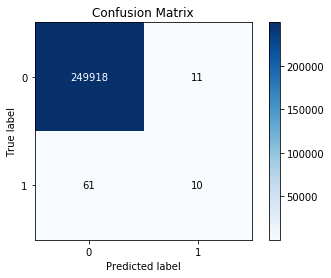

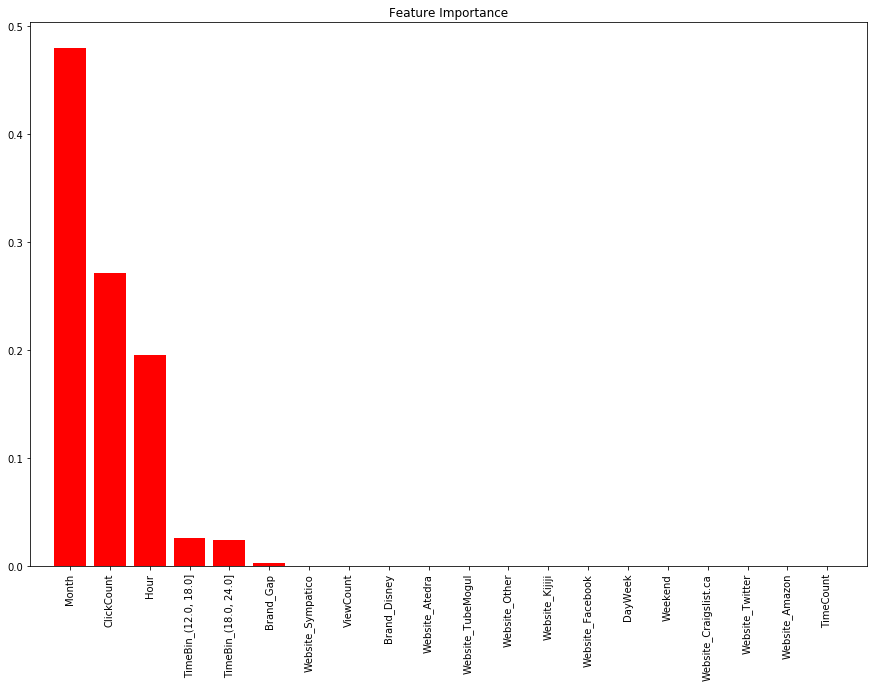

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\todds\Anaconda3\lib\

Model: Pipeline(steps=[('scale', StandardScaler()),
                ('sm', SMOTE(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 LogisticRegression(C=0.01, penalty='none', random_state=42))])


Cross Val F1 Score: 0.19495732278371708
Test F1 Score: 0.23404255319148937


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.48      0.15      0.23        71

    accuracy                           1.00    250000
   macro avg       0.74      0.58      0.62    250000
weighted avg       1.00      1.00      1.00    250000



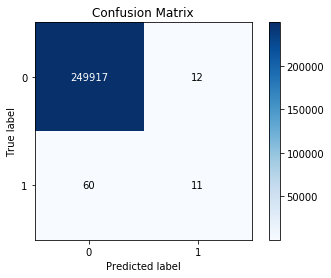

Model: Pipeline(steps=[('scale', StandardScaler()),
                ('sm', SMOTE(random_state=42, sampling_strategy=0.001)),
                ('mod',
                 RandomForestClassifier(max_depth=10, n_estimators=10,
                                        random_state=42))])


Cross Val F1 Score: 0.11807081807081807
Test F1 Score: 0.07792207792207793


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.50      0.04      0.08        71

    accuracy                           1.00    250000
   macro avg       0.75      0.52      0.54    250000
weighted avg       1.00      1.00      1.00    250000



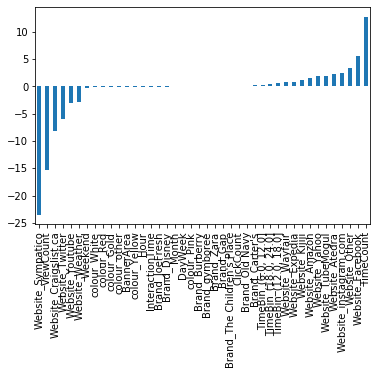

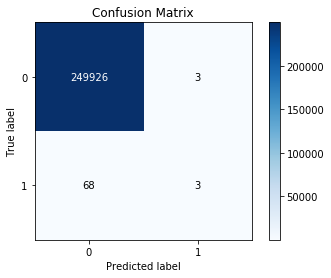

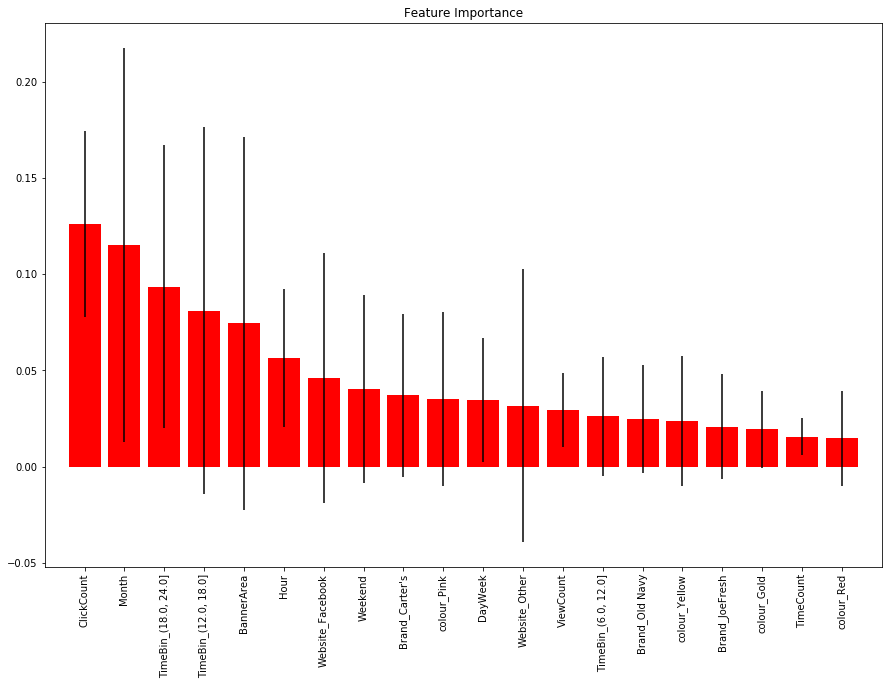

Model: Pipeline(steps=[('scale', StandardScaler()),
                ('sm',
                 RandomOverSampler(random_state=42, sampling_strategy=0.001)),
                ('mod',
                 DecisionTreeClassifier(max_depth=10, max_features=10,
                                        random_state=42))])


Cross Val F1 Score: 0.16869686411149826
Test F1 Score: 0.06818181818181819


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.18      0.04      0.07        71

    accuracy                           1.00    250000
   macro avg       0.59      0.52      0.53    250000
weighted avg       1.00      1.00      1.00    250000



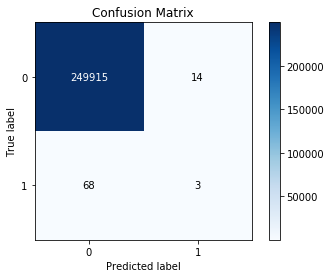

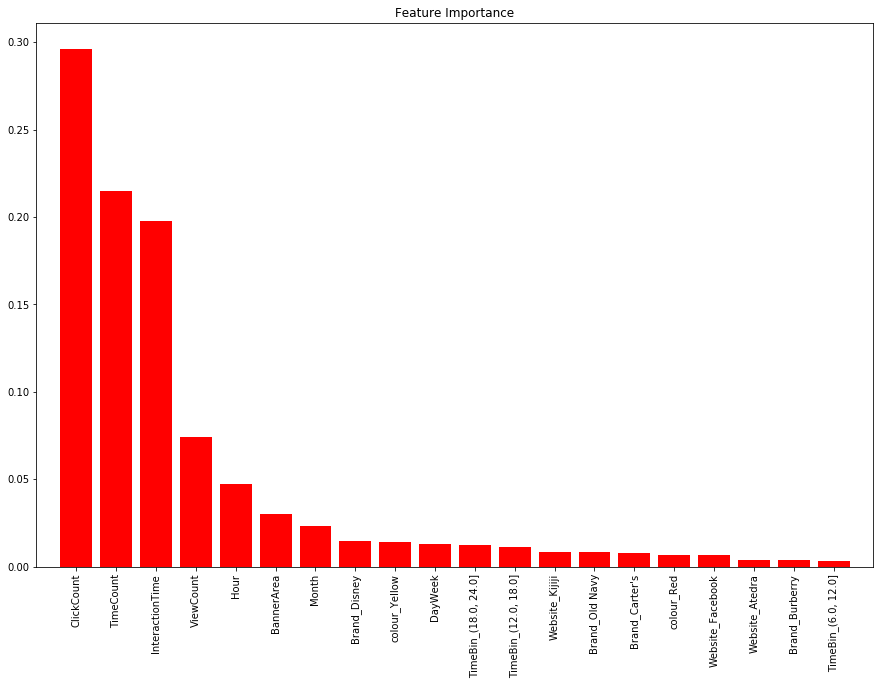

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\todds\Anaconda3\lib\

Model: Pipeline(steps=[('scale', StandardScaler()),
                ('sm',
                 RandomOverSampler(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 LogisticRegression(C=0.01, penalty='none', random_state=42))])


Cross Val F1 Score: 0.19495732278371708
Test F1 Score: 0.23157894736842108


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.46      0.15      0.23        71

    accuracy                           1.00    250000
   macro avg       0.73      0.58      0.62    250000
weighted avg       1.00      1.00      1.00    250000



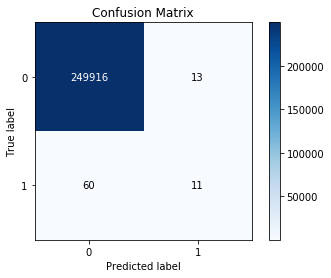

Model: Pipeline(steps=[('scale', StandardScaler()),
                ('sm',
                 RandomOverSampler(random_state=42, sampling_strategy=0.001)),
                ('mod',
                 RandomForestClassifier(max_depth=50, n_estimators=5,
                                        random_state=42))])


Cross Val F1 Score: 0.09907274471533958
Test F1 Score: 0.1


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.44      0.06      0.10        71

    accuracy                           1.00    250000
   macro avg       0.72      0.53      0.55    250000
weighted avg       1.00      1.00      1.00    250000



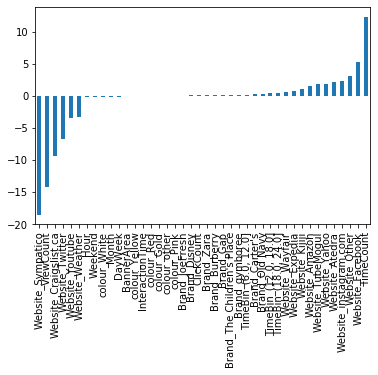

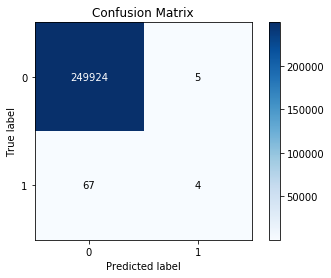

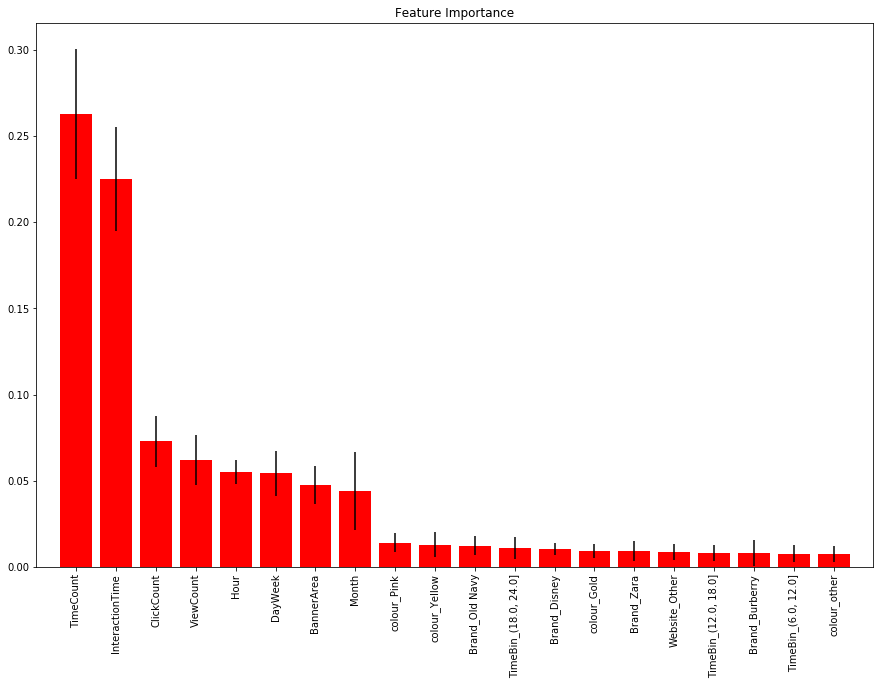

Wall time: 5min 5s


In [84]:
%%time

for samp in ['SMOTE','ROS']:
    for pipeline in END_models[samp]:
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)

        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring = 'f1')

        print(f'Model: {pipeline}')
        print("\n")
        print(f'Cross Val F1 Score: {scores.mean()}')
        print(f'Test F1 Score: {f1_score(y_pred, y_test)}')
        print("\n")
        print(classification_report(y_test, y_pred))
        skplt.metrics.plot_confusion_matrix(y_test, y_pred)
        plt.show();
        try:
            skplt.estimators.plot_feature_importances(pipeline['mod'], feature_names=X.columns, \
                                                      figsize=(15, 10), x_tick_rotation=90)
            plt.show();
        except:
            pd.Series(pipeline['mod'].coef_[0], index = X.columns).sort_values().plot(kind='bar')

## Decision Tree

#### Outputs below for individual models are similar, but different than the aggregated outputs above. These can be synchronized, but I wanted to test many different random states, parameters to tune, cv splits, etc. which has introduced an element of randomness / variance in our results.

### DT Grid Search

In [157]:
#performing 2 seperate grid searches, using SMOTE and ROS
#Different oversamplers will create different data, meaning different hyperparameters will optimize each model
%%time

DT = DecisionTreeClassifier(random_state=42)
kf = StratifiedKFold(n_splits = 5)
DTgrid = {}

for samp, sampler in zip(['SMOTE','ROS'], samplers):
    DTpipeline = Pipeline([('samp', sampler), ('mod', DT)])

    DTparams = {'samp__sampling_strategy': [0.001,0.01,0.1,0.25,0.5],
              'mod__max_depth': [5,10,15,25,50],
              'mod__max_features':[5,10,15,25,len(X.columns)],
              'mod__criterion': ['gini','entropy']
    }

    DTgrid[samp] = RandomizedSearchCV(DTpipeline, param_distributions = DTparams, scoring = 'f1', cv = kf, random_state=42)

    DTgrid[samp].fit(X_train, y_train)

In [159]:
#Create dictionary to hold different DT models (Original, w/ ROS, w/ SMOTE)
DTmodel = {}
DTmodel['Original'] = DTgrid['ROS'].best_estimator_['mod']
DTmodel['Original']

DecisionTreeClassifier(max_depth=5, max_features=10, random_state=42)

### DT w/ original data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.67      0.06      0.10        71

    accuracy                           1.00    250000
   macro avg       0.83      0.53      0.55    250000
weighted avg       1.00      1.00      1.00    250000



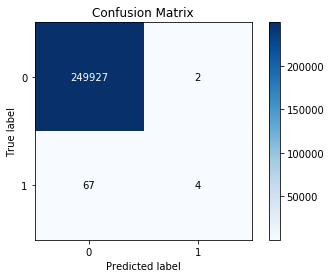

Cross Val F1 Score: 0.158049669628617
Test F1 Score: 0.1038961038961039


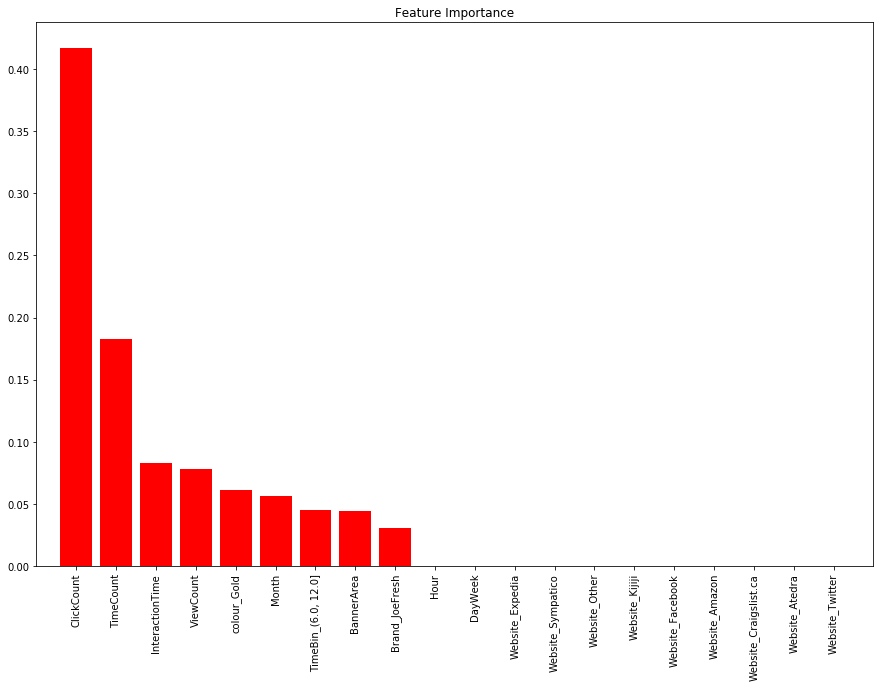

In [160]:
DTmodel['Original'].fit(X_train, y_train)

y_pred = DTmodel['Original'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(DTmodel['Original'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Cross Val F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

skplt.estimators.plot_feature_importances(DTmodel['Original'], feature_names=X.columns, figsize=(15, 10), x_tick_rotation=90)
plt.show();

### DT w/ Random Over Sampler

In [161]:
DTmodel['ROS'] = DTgrid['ROS'].best_estimator_
#DTmodel = DTgrid['ROS'].best_estimator_['mod']
#ros = DTgrid['ROS'].best_estimator_['samp']
#X_ros, y_ros = ros.fit_resample(X_train, y_train)
DTmodel['ROS']

Pipeline(steps=[('samp',
                 RandomOverSampler(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 DecisionTreeClassifier(max_depth=5, max_features=10,
                                        random_state=42))])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.45      0.14      0.22        71

    accuracy                           1.00    250000
   macro avg       0.73      0.57      0.61    250000
weighted avg       1.00      1.00      1.00    250000



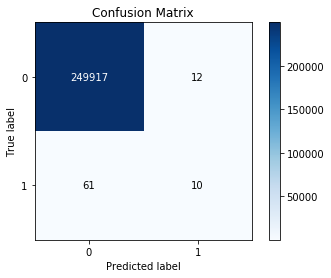

Cross Val Score: 0.2049206349206349
Test F1 Score: 0.21505376344086022


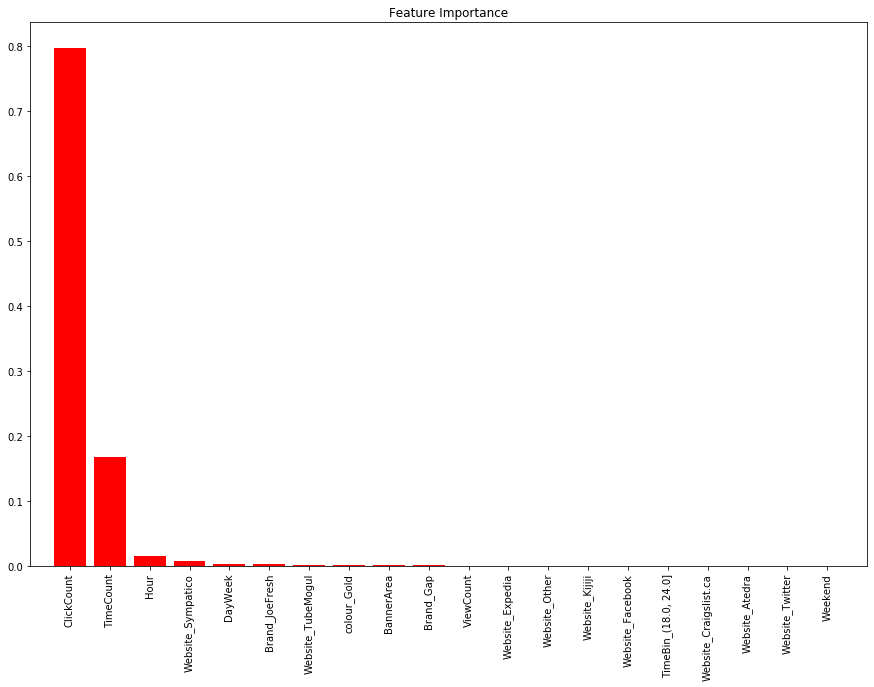

In [162]:
DTmodel['ROS'].fit(X_train, y_train)

y_pred = DTmodel['ROS'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(DTmodel['ROS'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Cross Val Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

skplt.estimators.plot_feature_importances(DTmodel['ROS']['mod'], feature_names=X.columns, figsize=(15, 10), x_tick_rotation=90)
plt.show();

### DT w/ SMOTE

In [163]:
DTmodel['SMOTE'] = DTgrid['SMOTE'].best_estimator_
DTmodel['SMOTE']

Pipeline(steps=[('samp', SMOTE(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 DecisionTreeClassifier(max_depth=5, max_features=10,
                                        random_state=42))])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.52      0.15      0.24        71

    accuracy                           1.00    250000
   macro avg       0.76      0.58      0.62    250000
weighted avg       1.00      1.00      1.00    250000



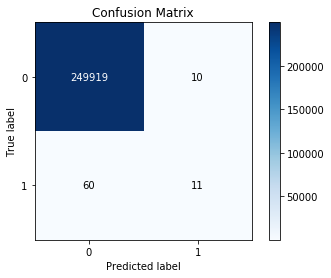

Cross Val Score: 0.1472042475526796
Test F1 Score: 0.23913043478260868


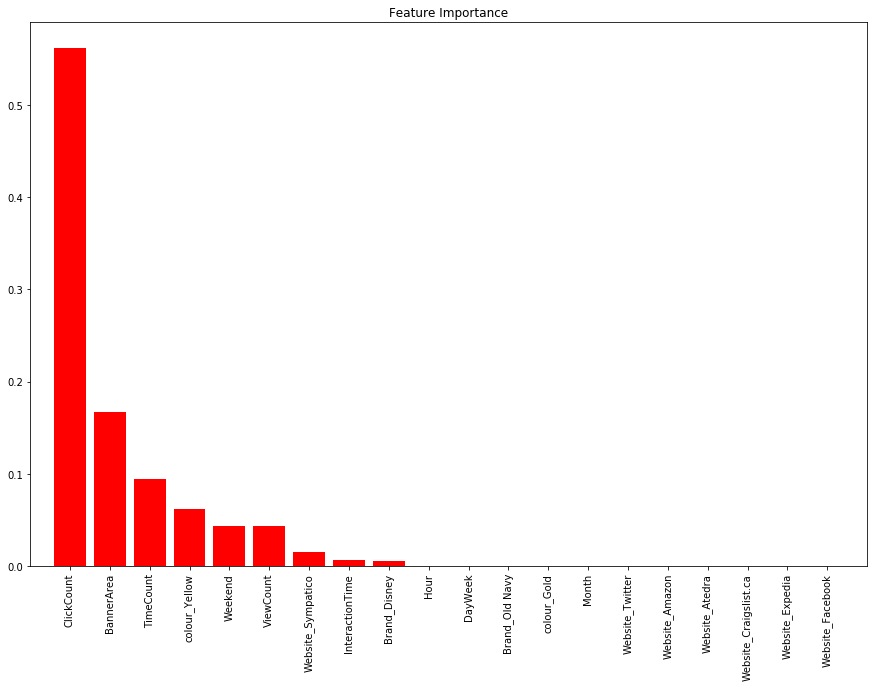

In [164]:
DTmodel['SMOTE'].fit(X_train, y_train)

y_pred = DTmodel['SMOTE'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(DTmodel['SMOTE'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Cross Val Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

skplt.estimators.plot_feature_importances(DTmodel['SMOTE']['mod'], feature_names=X.columns, figsize=(15, 10), x_tick_rotation=90)
plt.show();

#### ROS and SMOTE produce similair classification reports and both outperform the original data significantly. Both have issues to keep in mind: ROS overfits the training data, which is typical of the method. The feature importances for SMOTE seem a little more random and nonsensical than the other two DT models and there is a concern the SMOTE model is overfit to synthetic data. Both would be reasonable models to proceed with. We would test different random states to ensure SMOTE consistently outperformed ROS before selecting that model. 

## Random Forest

### RF Grid Search

In [53]:
%%time
RF = RandomForestClassifier(random_state=42)
kf = StratifiedKFold(n_splits = 5)
RFgrid = {}

for samp, sampler in zip(['SMOTE','ROS'], samplers):

    RFpipeline = Pipeline([('samp', sampler), ('mod', RF)])

    RFparams = {'samp__sampling_strategy': [0.001,0.01,0.1,0.25],
                'mod__max_depth': [5,10,15,25,50],
                'mod__n_estimators': [5,10,25,50,100],
                'mod__max_features': ['auto','sqrt'],
                'mod__criterion': ['gini','entropy']
    }

    RFgrid[samp] = RandomizedSearchCV(RFpipeline, param_distributions = RFparams, scoring = 'f1', cv = kf, random_state=15)

    RFgrid[samp].fit(X_train, y_train)

Wall time: 1h 10min 41s


In [54]:
RFgrid['ROS'].best_estimator_

Pipeline(steps=[('samp',
                 RandomOverSampler(random_state=42, sampling_strategy=0.25)),
                ('mod',
                 RandomForestClassifier(criterion='entropy', max_depth=50,
                                        n_estimators=25, random_state=42))])

In [55]:
RFgrid['SMOTE'].best_estimator_

Pipeline(steps=[('samp', SMOTE(random_state=42, sampling_strategy=0.001)),
                ('mod',
                 RandomForestClassifier(max_depth=15, n_estimators=5,
                                        random_state=42))])

In [56]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sm__sampling_strategy,param_mod__n_estimators,param_mod__max_depth,param_mod__criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,32.929447,0.778257,0.872676,0.088735,0.1,25,5,entropy,"{'sm__sampling_strategy': 0.1, 'mod__n_estimat...",0.153846,0.108108,0.153846,0.222222,0.050000,0.137605,0.056978,1
1,13.027569,0.302240,0.521456,0.039129,0.01,10,5,gini,"{'sm__sampling_strategy': 0.01, 'mod__n_estima...",0.142857,0.000000,0.055556,0.186047,0.055556,0.088003,0.067040,3
2,111.462482,2.761431,2.333930,0.139027,0.1,50,20,gini,"{'sm__sampling_strategy': 0.1, 'mod__n_estimat...",0.057143,0.000000,0.055556,0.000000,0.000000,0.022540,0.027610,8
3,968.322188,1895.769425,0.478724,0.200905,0.001,15,15,gini,"{'sm__sampling_strategy': 0.001, 'mod__n_estim...",0.153846,0.057143,0.157895,0.000000,0.000000,0.073777,0.070213,6
4,28.267907,9.397308,0.806399,0.223156,0.1,15,50,gini,"{'sm__sampling_strategy': 0.1, 'mod__n_estimat...",0.057143,0.055556,0.157895,0.100000,0.055556,0.085230,0.040121,4
5,23.688815,0.543989,0.653584,0.012193,0.01,10,15,entropy,"{'sm__sampling_strategy': 0.01, 'mod__n_estima...",0.100000,0.055556,0.105263,0.102564,0.000000,0.072677,0.040686,7
6,115.100480,1.585084,2.262930,0.184536,0.1,50,15,entropy,"{'sm__sampling_strategy': 0.1, 'mod__n_estimat...",0.111111,0.000000,0.105263,0.097561,0.055556,0.073898,0.041775,5
7,35.091464,0.645272,0.686512,0.051946,0.5,10,15,entropy,"{'sm__sampling_strategy': 0.5, 'mod__n_estimat...",0.005286,0.001385,0.005997,0.012723,0.003185,0.005715,0.003861,10
8,19.646032,0.930790,0.540797,0.021154,0.5,10,5,gini,"{'sm__sampling_strategy': 0.5, 'mod__n_estimat...",0.005329,0.004630,0.015228,0.006738,0.004790,0.007343,0.004012,9
9,20.853563,0.899651,0.513437,0.027902,0.5,5,50,gini,"{'sm__sampling_strategy': 0.5, 'mod__n_estimat...",0.105263,0.000000,0.195122,0.105263,0.054054,0.091940,0.064637,2


In [57]:
RFmodel = {}
RFmodel['Original'] = RFgrid['ROS'].best_estimator_['mod']
RFmodel['Original']

RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=25,
                       random_state=42)

### RF w/ Original Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.67      0.03      0.05        71

    accuracy                           1.00    250000
   macro avg       0.83      0.51      0.53    250000
weighted avg       1.00      1.00      1.00    250000



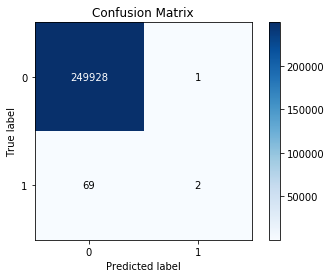

Cross Val F1 Score: 0.03305019305019305
Test F1 Score: 0.054054054054054064


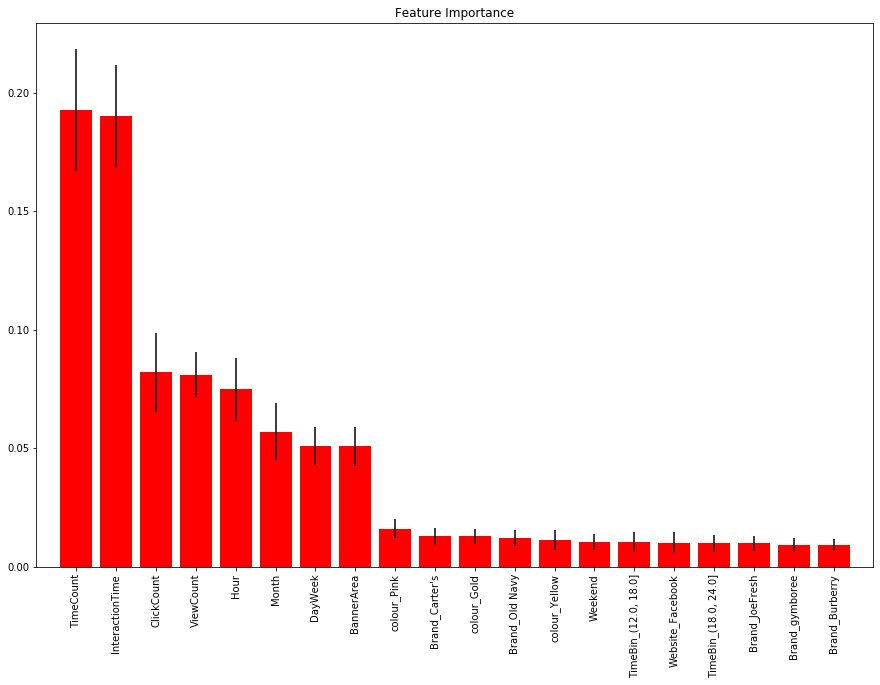

In [58]:
RFmodel['Original'].fit(X_train, y_train)

y_pred = RFmodel['Original'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(RFmodel['Original'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Cross Val F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

skplt.estimators.plot_feature_importances(RFmodel['Original'], feature_names=X.columns, figsize=(15, 10), x_tick_rotation=90)
plt.show();

### RF w/ Random Over Sampler

In [59]:
RFmodel['ROS'] = RFgrid['ROS'].best_estimator_
RFmodel['ROS']

Pipeline(steps=[('samp',
                 RandomOverSampler(random_state=42, sampling_strategy=0.25)),
                ('mod',
                 RandomForestClassifier(criterion='entropy', max_depth=50,
                                        n_estimators=25, random_state=42))])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.57      0.06      0.10        71

    accuracy                           1.00    250000
   macro avg       0.79      0.53      0.55    250000
weighted avg       1.00      1.00      1.00    250000



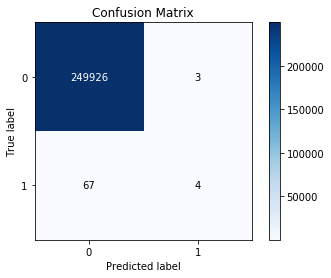

Training F1 Score: 0.12343514245953272
Test F1 Score: 0.10256410256410255


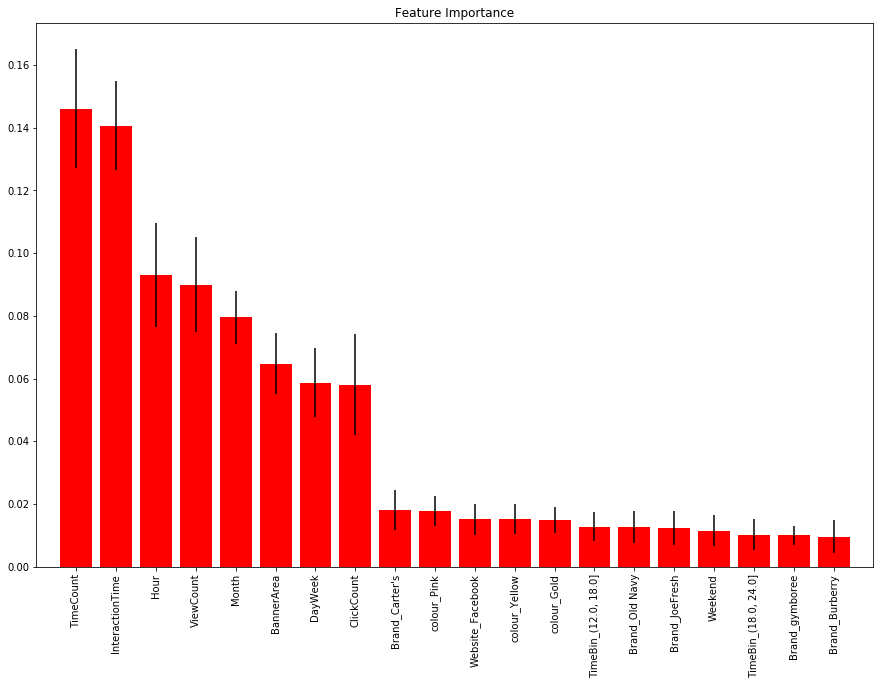

In [60]:
RFmodel['ROS'].fit(X_train, y_train)

y_pred = RFmodel['ROS'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(RFmodel['ROS'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Training F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

skplt.estimators.plot_feature_importances(RFmodel['ROS']['mod'], feature_names=X.columns, figsize=(15, 10), x_tick_rotation=90)
plt.show();

### RF w/ SMOTE

In [61]:
RFmodel['SMOTE'] = RFgrid['SMOTE'].best_estimator_
RFmodel['SMOTE']
#smote = RFgrid['SMOTE'].best_estimator_['samp']
#SMOTE(sampling_strategy = 0.1)
#X_smote, y_smote = smote.fit_resample(X_train, y_train)

Pipeline(steps=[('samp', SMOTE(random_state=42, sampling_strategy=0.001)),
                ('mod',
                 RandomForestClassifier(max_depth=15, n_estimators=5,
                                        random_state=42))])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.62      0.07      0.13        71

    accuracy                           1.00    250000
   macro avg       0.81      0.54      0.56    250000
weighted avg       1.00      1.00      1.00    250000



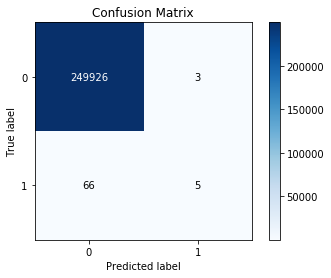

Training F1 Score: 0.0928744939271255
Test F1 Score: 0.12658227848101267


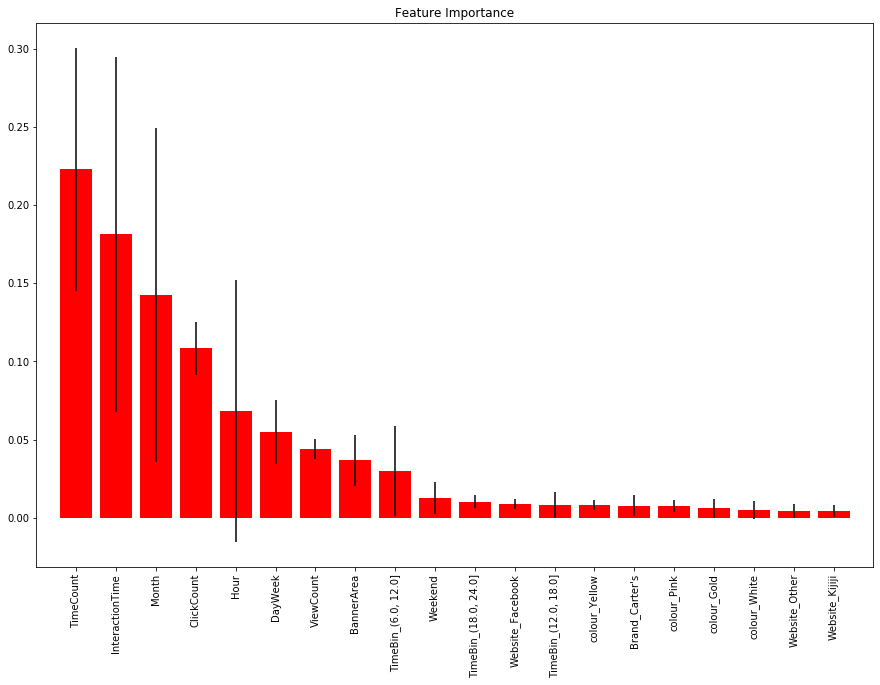

In [62]:
RFmodel['SMOTE'].fit(X_train, y_train)

y_pred = RFmodel['SMOTE'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(RFmodel['SMOTE'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Training F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

skplt.estimators.plot_feature_importances(RFmodel['SMOTE']['mod'], feature_names=X.columns, figsize=(15, 10), x_tick_rotation=90)
plt.show();

#### The strongest Random Forest model is the SMOTE model. It performs slightly better than the ROS model on the test set, but the ROS model is potentially overfit to the training set making it less robust and less likely to fit well to unseen test sets. We prefer SMOTE because it is more likely it has keyed in on the signal and not the noise; the feature importance graphs support this idea. Suprisingly the DT models outpeform the RF models, suggesting the pattern we are trying to capture may be relatively simple and RF is missing it due to overfitting. 

## Logistic Regression (BEST MODEL!)

### LR Grid Search

In [ ]:
%%time
#Data must be scaled for LR
#Tuned w/ f1

LR = LogisticRegression(random_state=42)
#kf = StratifiedKFold(n_splits = 5)
LRgrid = {}

for samp, sampler in zip(['SMOTE','ROS'], samplers):

    pipeline = Pipeline([('scale', scaler), ('samp', sampler), ('mod', LR)])

    LRparams = {
                'samp__sampling_strategy': [0.001,0.01,0.1,0.25],
                'mod__C':[0.01,0.1,1,10,100],
                'mod__penalty':['none','l1','l2'],
                'mod__max_iter':[25,50,100,200,500],
                'mod__solver':['lbfgs','liblinear']
                }

    LRgrid[samp] = RandomizedSearchCV(pipeline, param_distributions = LRparams, scoring = 'f1', cv = 5, random_state=15)

    LRgrid[samp].fit(X_train, y_train)

In [66]:
LRgrid['SMOTE'].best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('samp', SMOTE(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 LogisticRegression(C=100, max_iter=25, penalty='l1',
                                    random_state=42, solver='liblinear'))])

### LR w/ Original Data

In [67]:
#We use the model hyperparameters from the 'SMOTE' grid search, but do not use an oversampler here
#Small gains would come from tuning the hyperparams on original data, but in testing the original data never produced best model
#Therefore omitted to save time

LRmodel = {}
LRmodel['Original'] = LRgrid['ROS'].best_estimator_['mod']
LRmodel['Original']

LogisticRegression(C=100, max_iter=25, penalty='l1', random_state=42,
                   solver='liblinear')

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.50      0.04      0.08        71

    accuracy                           1.00    250000
   macro avg       0.75      0.52      0.54    250000
weighted avg       1.00      1.00      1.00    250000



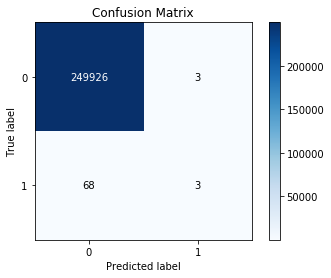

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

Training F1 Score: 0.043859649122807015
Test F1 Score: 0.07792207792207793


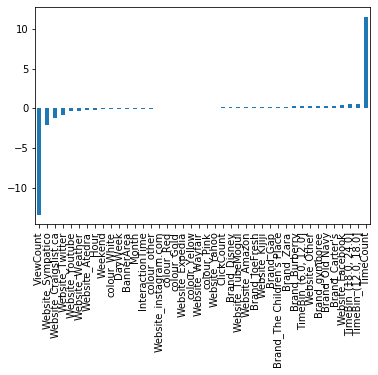

In [68]:
pipeline = Pipeline([('scale', scaler), ('mod', LRmodel['Original'])])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring = 'f1')
print(f'Training F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

pd.Series(pipeline['mod'].coef_[0], index = X.columns).sort_values().plot(kind='bar');

### LR w/ Random Over Sampler

In [69]:
LRmodel['ROS'] = LRgrid['ROS'].best_estimator_
LRmodel['ROS']

Pipeline(steps=[('scale', StandardScaler()),
                ('samp',
                 RandomOverSampler(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 LogisticRegression(C=100, max_iter=25, penalty='l1',
                                    random_state=42, solver='liblinear'))])

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.46      0.15      0.23        71

    accuracy                           1.00    250000
   macro avg       0.73      0.58      0.62    250000
weighted avg       1.00      1.00      1.00    250000



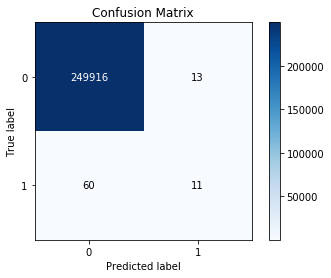

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

Training F1 Score: 0.19495732278371708
Test F1 Score: 0.23157894736842108


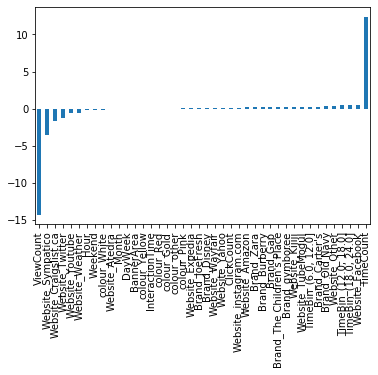

In [70]:
LRmodel['ROS'].fit(X_train, y_train)

y_pred = LRmodel['ROS'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(LRmodel['ROS'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Training F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

pd.Series(LRmodel['ROS']['mod'].coef_[0], index = X.columns).sort_values().plot(kind='bar');

In [71]:
print(roc_auc_score(y_test, y_pred))

0.5774387813462968


### LR w/ SMOTE

### Using Logisitc Regression w/ SMOTE we were able to predict 11/71 clicks while only predicting 12 incorrect clicks. While models can always be improved upon this is a good start considering how imbalanced the dataset is. Consider that we made predictions on 250000 instances, so this is a needle in a haystack scenario that our best model did an admirable job of predicting. The model has clearly keyed in on some signal and will very likely have some value in predicting click through rate on unseen data. 

In [72]:
LRmodel['SMOTE'] = LRgrid['SMOTE'].best_estimator_
LRmodel['SMOTE']

Pipeline(steps=[('scale', StandardScaler()),
                ('samp', SMOTE(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 LogisticRegression(C=100, max_iter=25, penalty='l1',
                                    random_state=42, solver='liblinear'))])

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.48      0.15      0.23        71

    accuracy                           1.00    250000
   macro avg       0.74      0.58      0.62    250000
weighted avg       1.00      1.00      1.00    250000



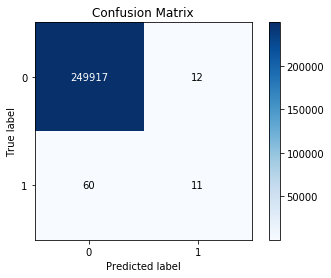

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

Training F1 Score: 0.19495732278371708
Test F1 Score: 0.23404255319148937


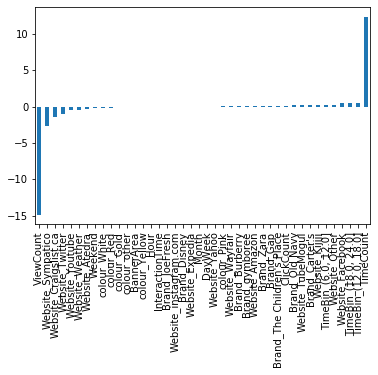

In [73]:
LRmodel['SMOTE'].fit(X_train, y_train)  

y_pred = LRmodel['SMOTE'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(LRmodel['SMOTE'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Training F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

pd.Series(LRmodel['SMOTE']['mod'].coef_[0], index = X.columns).sort_values().plot(kind='bar');

### LR w/ PCA

#### Exploring whether incorporating PCA can improve the model results. PCA attempts to reduce the complexity of the data by reducing the number of features by combining the principal components of two features. While it allows us to find several additional click cases, it also leads to thousands of erroneous click predictions. This is not necessarily a bad thing and depends on the value of a finding a click to the business and the cost of erronesouly predicting a click. This would be a conversation to have with the business team before exporing this method further. 

In [89]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

C:\Users\todds\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


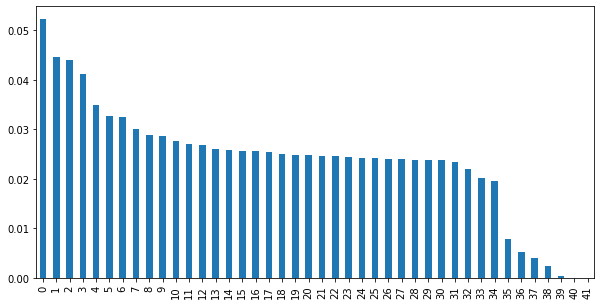

In [90]:
pd.Series(pca.explained_variance_ratio_).plot(kind='bar', figsize = (10, 5));
#pca was fit to the data in fit_transfrom above

C:\Users\todds\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='line')` instead of `Series.plot('line',)`.
  """Entry point for launching an IPython kernel.


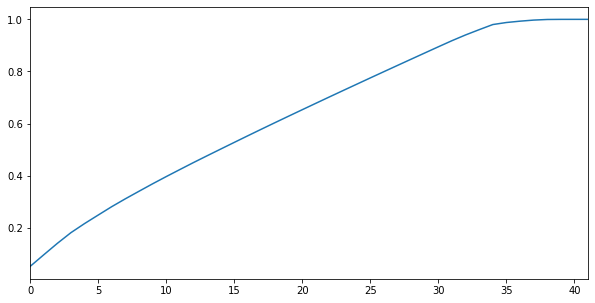

In [91]:
pd.Series(pca.explained_variance_ratio_.cumsum()).plot(kind='line', figsize=(10,5));

In [549]:
X_train_scaled.shape

(750000, 42)

In [101]:
#Define how many principle components you want
#We choose 34 here because according to the graph above components beyond that do not help to explain variance
#Data is then reduced to that many columns / principal components
pca = PCA(34)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

X_train_pca.shape

(750000, 34)

In [102]:
#Logisitc Regression w/ PCA

LRmodel = LRgrid['ROS'].best_estimator_['mod']
LRmodel.fit(X_train_pca, y_train)
y_pred = LRmodel.predict(X_test_pca)
scores = cross_val_score(LRmodel, X_train_pca, y_train, cv=5)
print(scores.mean())
print(classification_report(y_test, y_pred))

C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\todds\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

0.9997693333333334
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    249929
           1       0.00      0.15      0.01        71

    accuracy                           0.99    250000
   macro avg       0.50      0.57      0.50    250000
weighted avg       1.00      0.99      0.99    250000



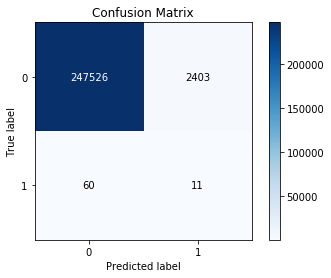

In [103]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred);

## XGB

### XGB Grid Search

In [43]:
%%time
#Tuned w/ f1
from xgboost import XGBClassifier
XGB = XGBClassifier(random_state = 42)
kf = StratifiedKFold(n_splits = 5)
XGBgrid = {}

for samp, sampler in zip(['SMOTE','ROS'], samplers):

    pipeline = Pipeline([('scale', scaler), ('samp', sampler), ('mod', XGB)])

    XGBparams = {'samp__sampling_strategy': [0.001,0.01,0.1,0.25],
                'mod__max_depth':[3,5,8,10],
                'mod__n_estimators': [5,10,15,25],
                #'mod__colsample_bytree': [0.1,0.3,0.5,0.7,0.9],
                'mod__learning_rate': [0.01,0.1,0.5,1],
                'mod__reg_alpha':[0.01,0.1,1,10]
                #booster
                }

    XGBgrid[samp] = RandomizedSearchCV(pipeline, param_distributions = XGBparams, scoring = 'f1', cv = kf, random_state=15)

    XGBgrid[samp].fit(X_train, y_train)

Wall time: 1h 41min 55s


### XGB  w/ ROS

In [47]:
XGBmodel['ROS'] = XGBgrid['ROS'].best_estimator_
XGBmodel['ROS']

Pipeline(steps=[('scale', StandardScaler()),
                ('samp',
                 RandomOverSampler(random_state=42, sampling_strategy=0.01)),
                ('mod',
                 XGBClassifier(learning_rate=0.5, max_depth=8, n_estimators=5,
                               random_state=42, reg_alpha=0.1))])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.25      0.13      0.17        71

    accuracy                           1.00    250000
   macro avg       0.62      0.56      0.58    250000
weighted avg       1.00      1.00      1.00    250000



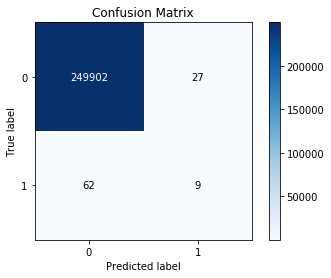

Training F1 Score: 0.13774565213572137
Test F1 Score: 0.16822429906542055


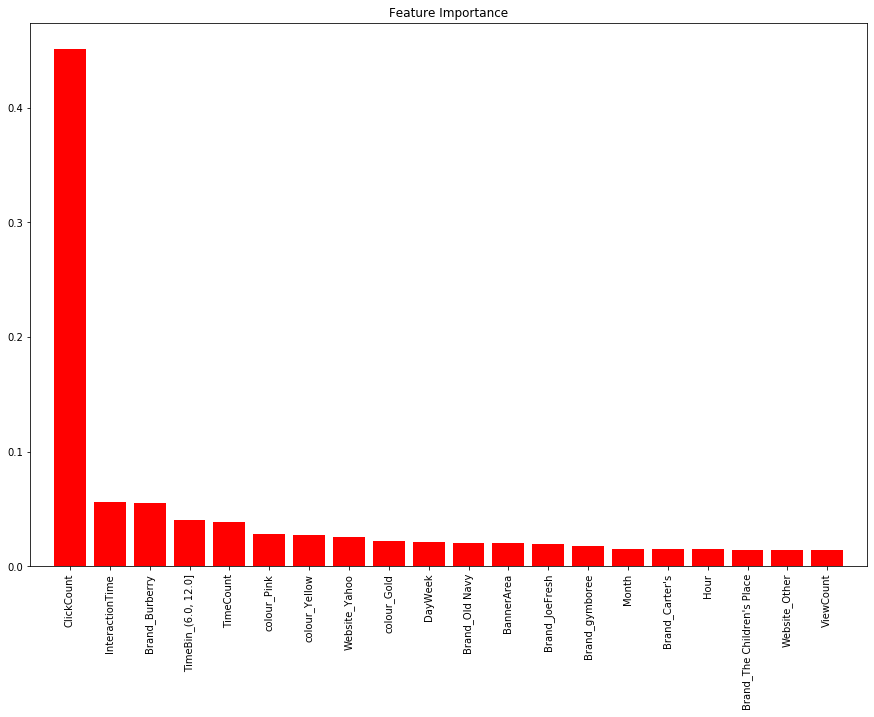

In [48]:
XGBmodel['ROS'].fit(X_train, y_train)

y_pred = XGBmodel['ROS'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(XGBmodel['ROS'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Training F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

skplt.estimators.plot_feature_importances(XGBmodel['ROS']['mod'], feature_names=X.columns, figsize=(15, 10), x_tick_rotation=90)
plt.show();

### XGB  w/ SMOTE

In [131]:
XGBmodel['SMOTE'] = XGBgrid['SMOTE'].best_estimator_
XGBmodel['SMOTE']

Pipeline(steps=[('scale', StandardScaler()),
                ('samp', SMOTE(random_state=42, sampling_strategy=0.001)),
                ('mod',
                 XGBClassifier(learning_rate=0.5, max_depth=10, n_estimators=10,
                               random_state=42, reg_alpha=0.1))])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249929
           1       0.60      0.08      0.15        71

    accuracy                           1.00    250000
   macro avg       0.80      0.54      0.57    250000
weighted avg       1.00      1.00      1.00    250000



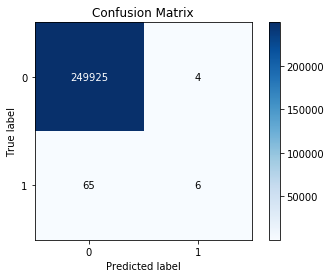

Training F1 Score: 0.13785479960062758
Test F1 Score: 0.14814814814814814


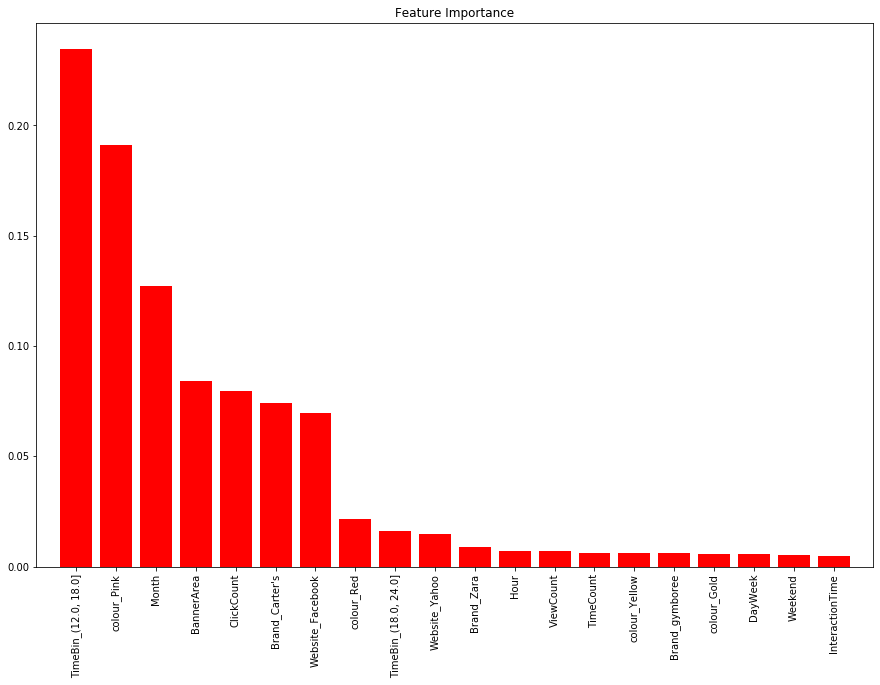

In [132]:
XGBmodel['SMOTE'].fit(X_train, y_train)

y_pred = XGBmodel['SMOTE'].predict(X_test)

print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show();

scores = cross_val_score(XGBmodel['SMOTE'], X_train, y_train, cv=5, scoring = 'f1')
print(f'Training F1 Score: {scores.mean()}')
print(f'Test F1 Score: {f1_score(y_pred, y_test)}')

skplt.estimators.plot_feature_importances(XGBmodel['SMOTE']['mod'], feature_names=X.columns, figsize=(15, 10), x_tick_rotation=90)
plt.show();

#### XGB w/ ROS finds roughly as many clicks as some methods, but makes several more erroneous predictions than LR. XGB w/ SMOTE finds less clicks than some methods, but also make very few errneous predictions. We are likely more concerned with finding clicks and less concerned about bad predictions so this method is unlikely to be selected going forward. 